After downloading a zip file to GCS, we likely want to unzip it so that we can work with individual images instead of loading and unzipping the entire zip in a notebook local environment every time.

In [ ]:
!gcloud init

In [ ]:
# allows sliced object downloads for faster downloading
!pip3 install --no-cache-dir -U crcmod

In [ ]:
# bucket_name = 'adv-tdl-data-bucket'
# zip_file_path = 'Dataset.zip'
# output_folder = 'Dataset1'

# # get data
# !gsutil cp gs://{bucket_name}/{zip_file_path} /content/temp.zip

# # get labeling csv
# ! gsutil cp gs://{bucket_name}/Dataset_3_20_2024.csv /content/labels.csv

Copying gs://adv-tdl-data-bucket/Dataset.zip...
\ [1 files][ 20.9 GiB/ 20.9 GiB]   54.9 MiB/s                                   
Operation completed over 1 objects/20.9 GiB.                                     
Copying gs://adv-tdl-data-bucket/Dataset_3_20_2024.csv...
/ [1 files][  1.6 MiB/  1.6 MiB]                                                
Operation completed over 1 objects/1.6 MiB.                                      


In [ ]:
import pandas as pd
# label_df = pd.read_csv('/content/labels.csv').set_index('Image Data ID')
# label_df

## Dataset.zip preprocessing


In [ ]:
import pandas as pd
label_df = pd.read_csv('Dataset_3_20_2024.csv')
label_df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I495208,92834,Prodromal,M,66,BL,MRI,MPRAGE GRAPPA2,Original,3/20/2015,DCM,NaN
1,I495209,92834,Prodromal,M,66,BL,MRI,Axial T2 TSE with Fat Sat,Original,3/20/2015,DCM,NaN
2,I440709,91837,Prodromal,M,74,BL,MRI,AX DUAL_TSE,Original,3/04/2014,DCM,NaN
3,I440711,91837,Prodromal,M,74,BL,MRI,Cor FLAIR TI_2800ms,Original,3/04/2014,DCM,NaN
4,I440710,91837,Prodromal,M,74,BL,MRI,SAG 3D T1,Original,3/04/2014,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17437,I1473172,100001,PD,M,67,BL,MRI,SAG 3D MPRAGE,Original,10/07/2020,DCM,NaN
17438,I1473183,100001,PD,M,67,BL,MRI,AX T2 GRE MT,Original,10/07/2020,DCM,NaN
17439,I1658557,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN
17440,I1658550,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN


In [ ]:
import os
import pandas as pd

def collect_files_with_subject_id(dir_path, file_data, subject_id=None):
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        # If the item is a directory, we either set the subject ID (if we're in the /content/PPMI/{subject} directory)
        # or we recurse into the directory
        if os.path.isdir(item_path):
            if dir_path.endswith('PPMI'):  # Checking if we're directly under /content/PPMI
                # The folder name here is the subject ID
                collect_files_with_subject_id(item_path, file_data, item)
            else:
                # Recurse into subdirectories
                collect_files_with_subject_id(item_path, file_data, subject_id)
        else:
            # If it's a file, add its path and the current subject ID to the list
            file_data.append({'Subject': subject_id, 'File Name': os.path.basename(item_path)})

# Initialize an empty list to store the file data
file_data = []

# Replace this with the path to your PPMI directory
ppmi_base_path = '/content/PPMI'
collect_files_with_subject_id(ppmi_base_path, file_data)

# Convert the list of file data to a pandas DataFrame
file_df = pd.DataFrame(file_data)
file_df




,Subject,File Name
0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
...,...,...
455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...
455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...
455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...
455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...


In [ ]:
import os
import pandas as pd

def collect_files_info(dir_path, file_data, subject_id=None):
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        if os.path.isdir(item_path):
            # If the directory's name is numeric, it's considered a subject ID
            if dir_path.endswith('PPMI') and item.isdigit():
                collect_files_info(item_path, file_data, item)
            else:
                collect_files_info(item_path, file_data, subject_id)
        else:
            # Extract Image Data ID (the folder name before the file)
            image_data_id = item_path.split('/')[-2]
            # Check if the Image Data ID follows the expected pattern (e.g., starts with 'I')
            if image_data_id.startswith('I'):
                file_data.append({'Subject': subject_id, 'Image Data ID': image_data_id, 'File Name': os.path.basename(item_path)})

# Initialize an empty list to store the file data
file_data = []

# Replace this with the path to your PPMI directory
ppmi_base_path = '/content/PPMI'
collect_files_info(ppmi_base_path, file_data)

# Convert the list of file data to a pandas DataFrame
file_info_df = pd.DataFrame(file_data)


In [ ]:
file_info_df

,Subject,Image Data ID,File Name
0,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
1,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
2,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
3,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
4,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
...,...,...,...
455021,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...
455022,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...
455023,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...
455024,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...


In [ ]:
file_info_df = file_info_df[['Subject', 'File Name']]

In [ ]:
file_info_df

,Subject,File Name
0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
...,...,...
455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...
455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...
455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...
455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...


In [ ]:
file_info_df['Subject'] = file_info_df['Subject'].astype(str)
label_df['Subject'] = label_df['Subject'].astype(str)

<ipython-input-9-c8eb5adbe10a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_info_df['Subject'] = file_info_df['Subject'].astype(str)


In [ ]:
# Create a dictionary where the key is the Subject and the value is the Group
group_mapping = label_df.set_index('Subject')['Group'].to_dict()

# Map the Group values to file_info_df using the map function
file_info_df['Group'] = file_info_df['Subject'].map(group_mapping)

In [ ]:
file_info_df

,Subject,File Name,Group
0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
...,...,...,...
455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...,PD
455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...,PD
455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...,PD
455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...,PD


In [ ]:
file_info_df.to_csv('labeled_data.csv')

# Dataset1.zip Preprocessing

In [1]:
import pandas as pd
label_df = pd.read_csv('Dataset_3_20_2024.csv')
label_df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I495208,92834,Prodromal,M,66,BL,MRI,MPRAGE GRAPPA2,Original,3/20/2015,DCM,NaN
1,I495209,92834,Prodromal,M,66,BL,MRI,Axial T2 TSE with Fat Sat,Original,3/20/2015,DCM,NaN
2,I440709,91837,Prodromal,M,74,BL,MRI,AX DUAL_TSE,Original,3/04/2014,DCM,NaN
3,I440711,91837,Prodromal,M,74,BL,MRI,Cor FLAIR TI_2800ms,Original,3/04/2014,DCM,NaN
4,I440710,91837,Prodromal,M,74,BL,MRI,SAG 3D T1,Original,3/04/2014,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17437,I1473172,100001,PD,M,67,BL,MRI,SAG 3D MPRAGE,Original,10/07/2020,DCM,NaN
17438,I1473183,100001,PD,M,67,BL,MRI,AX T2 GRE MT,Original,10/07/2020,DCM,NaN
17439,I1658557,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN
17440,I1658550,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN


In [2]:
import os
import pandas as pd

def collect_files_with_subject_id(dir_path, file_data, subject_id=None):
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        # If the item is a directory, we either set the subject ID (if we're in the /content/PPMI_test/{subject} directory)
        # or we recurse into the directory
        if os.path.isdir(item_path):
            if dir_path.endswith('PPMI_test'):  # Checking if we're directly under /content/PPMI_test
                # The folder name here is the subject ID
                collect_files_with_subject_id(item_path, file_data, item)
            else:
                # Recurse into subdirectories
                collect_files_with_subject_id(item_path, file_data, subject_id)
        else:
            # If it's a file, add its path and the current subject ID to the list
            file_data.append({'Subject': subject_id, 'File Name': os.path.basename(item_path)})

# Initialize an empty list to store the file data
file_data = []

# Replace this with the path to your PPMI directory
ppmi_base_path = '/content/PPMI_test'
collect_files_with_subject_id(ppmi_base_path, file_data)

# Convert the list of file data to a pandas DataFrame
file_df = pd.DataFrame(file_data)
file_df




,Subject,File Name
0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
...,...,...
455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...
455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...
455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...
455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...


In [3]:
import os
import pandas as pd

def collect_files_info(dir_path, file_data, subject_id=None):
    for item in os.listdir(dir_path):
        item_path = os.path.join(dir_path, item)
        if os.path.isdir(item_path):
            # If the directory's name is numeric, it's considered a subject ID
            if dir_path.endswith('PPMI_test') and item.isdigit():
                collect_files_info(item_path, file_data, item)
            else:
                collect_files_info(item_path, file_data, subject_id)
        else:
            # Extract Image Data ID (the folder name before the file)
            image_data_id = item_path.split('/')[-2]
            # Check if the Image Data ID follows the expected pattern (e.g., starts with 'I')
            if image_data_id.startswith('I'):
                file_data.append({'Subject': subject_id, 'Image Data ID': image_data_id, 'File Name': os.path.basename(item_path)})

# Initialize an empty list to store the file data
file_data = []

# Replace this with the path to your PPMI directory
ppmi_base_path = '/content/PPMI_test'
collect_files_info(ppmi_base_path, file_data)

# Convert the list of file data to a pandas DataFrame
file_info_df = pd.DataFrame(file_data)


In [4]:
file_info_df

,Subject,Image Data ID,File Name
0,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
1,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
2,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
3,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
4,3770,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
...,...,...,...
455021,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...
455022,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...
455023,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...
455024,4112,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...


In [5]:
file_info_df = file_info_df[['Subject', 'File Name']]

In [6]:
file_info_df

,Subject,File Name
0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...
...,...,...
455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...
455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...
455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...
455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...


In [7]:
file_info_df['Subject'] = file_info_df['Subject'].astype(str)
label_df['Subject'] = label_df['Subject'].astype(str)

<ipython-input-7-c8eb5adbe10a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_info_df['Subject'] = file_info_df['Subject'].astype(str)


In [8]:
# Create a dictionary where the key is the Subject and the value is the Group
group_mapping = label_df.set_index('Subject')['Group'].to_dict()

# Map the Group values to file_info_df using the map function
file_info_df['Group'] = file_info_df['Subject'].map(group_mapping)

In [9]:
file_info_df

,Subject,File Name,Group
0,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
1,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
2,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
3,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
4,3770,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,PD
...,...,...,...
455021,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...,PD
455022,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...,PD
455023,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...,PD
455024,4112,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...,PD


In [10]:
file_info_df.to_csv('test_labeled_data.csv')

## Eric's code

In [ ]:
import zipfile

image_ids = set()
with zipfile.ZipFile("/content/temp.zip", "r") as zip_ref:
  for file_info in zip_ref.infolist():
    filename = file_info.filename
    fileid = filename.split('/')[4]
    if fileid not in image_ids:
      # new fileid processed
      image_ids.add(fileid)
      try:
        print(f"{fileid}: {label_df.loc[fileid, 'Group']}")
      except:
        print(f"{fileid}: NO LABEL FOUND")

In [ ]:
import os

def unzip_and_upload(bucket_name, zip_file_path, output_folder):
  """unzip a zip from GCS and upload the constituents back into GCS"""
  # download zip to local environment
  !gsutil cp gs://{bucket_name}/{zip_file_path} /content/temp.zip

  # unzip locally
  !unzip /content/temp.zip -d {output_folder}

  # upload constituent files to GCS
  !gsutil -m cp -r {output_folder}/* gs://{bucket_name}/{output_folder}/

  # clean local files
  os.remove('/content/temp.zip')
  os.system("rm -rf " + output_folder)

unzip_and_upload(bucket_name, zip_file_path, output_folder)

In [ ]:
#from google.colab import auth
#auth.authenticate_user()
#from google.cloud import storage

In [ ]:
# unzip zip in local environment
# this is a big operation to do in a local environment
# we may want to only do this once and write the unzipped contents back to the bucket
import zipfile
with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
from google.cloud import storage
import zipfile
import io

# Create a client
client = storage.Client()

# Access your bucket
bucket = client.get_bucket('-name')

# Specify the zip file path in the bucket
zip_file_blob = bucket.get_blob('path/to/your/zipfile.zip')

# Download the zip file into memory
zip_file_contents = zip_file_blob.download_as_string()

# Extract the contents of the zip file
with zipfile.ZipFile(io.BytesIO(zip_file_contents)) as z:
    # List all files in the zip file
    file_list = z.namelist()

    # Extract each file
    for file_name in file_list:
        # Extract the file content
        file_content = z.read(file_name)

        # Do whatever you want with the file content, for example:
        print("Contents of", file_name, ":\n", file_content.decode())

In [ ]:
from google.cloud import storage

# load bucket
client = storage.Client()
bucket = client.get_bucket('adv-tdl-data-bucket')

# load zip blobs
zip_blob1 = bucket.get_blob('Dataset.zip')
#zip_data1 = zip_blob1.download_as_string()
zip_blob2 = bucket.get_blob('Dataset2.zip')
#zip_data2 = zip_blob2.download_as_string()

zip_data1 = zip_blob1.download_as_string()

In [ ]:
zip_blob1

<Blob: adv-tdl-data-bucket, Dataset.zip, 1710107597575489>

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import keras
#import dask.dataframe as dd
import os
import pydicom as dicom
import matplotlib.pylab as plt

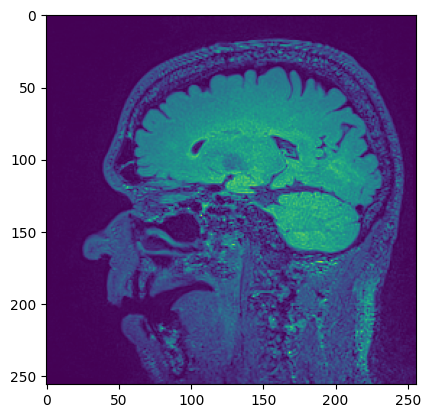

In [ ]:
path = '/content/PPMI/100001/3D_T2_FLAIR/2020-10-07_13_51_32.0/I1473191/PPMI_100001_MR_3D_T2_FLAIR__br_raw_20210723152845317_80_S1047641_I1473191.dcm'

ds = dicom.dcmread(path)

plt.imshow(ds.pixel_array)